<a href="https://colab.research.google.com/github/bleamer/eva5/blob/master/W5/MNIST_S4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook implements a CNN to classify MNIST image dataset and achieves 99% accuracy

[Summary](#scrollTo=_-dP1v2XvuJe) at the bottom of the notebook

In [1]:
targets = '''
1. Keep *Trainable* parameters to < 10,000
1. Use Regularization techniques like batch normalization, dropout, global average pooling  
1. Use any image Augumentation
1. Increase train and test accuracy above 99.2%
1. Avoid overfitting
'''

# Import Libraries

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt




## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 

Here is the list of all the transformations which come pre-built with PyTorch

1.   Compose
2.   ToTensor
3.   ToPILImage
4. Normalize
5. Resize
6. Scale
7. CenterCrop
8. Pad
9. Lambda
10. RandomApply
11. RandomChoice
12. RandomOrder
13. RandomCrop
14. RandomHorizontalFlip
15. RandomVerticalFlip
16. RandomResizedCrop
17. RandomSizedCrop
18. FiveCrop
19. TenCrop
20. LinearTransformation
21. ColorJitter
22. RandomRotation
23. RandomAffine
24. Grayscale
25. RandomGrayscale
26. RandomPerspective
27. RandomErasing

You can read more about them [here](https://pytorch.org/docs/stable/_modules/torchvision/transforms/transforms.html)

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

import psutil
CPU_COUNT =  psutil.cpu_count()

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=CPU_COUNT, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# How did we get those mean and std values which we used above?

Let's run a small experiment

In [6]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1305)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


# The model
Let's start with the model we first saw

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26, Receptive Field = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24 Receptive Field = 5
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.1)
        ) # output_size = 22 Receptive Field = 7

        #------------------------------------------

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11 Receptive Field = 14
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 11 Receptive Field = 14

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 9 Receptive Field = 16
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.1)
        ) # output_size = 7 Receptive Field = 18

        #-------------------------------------------

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 7 Receptive Field = 20
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 7 Receptive Field = 20
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 7 Receptive Field = 20
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5),
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        ) # output_size = 1 Receptive Field = 28

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        # x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             900
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 16, 22, 22]           1,440
       BatchNorm2d-8           [-1, 16, 22, 22]              32
              ReLU-9           [-1, 16, 22, 22]               0
          Dropout-10           [-1, 16, 22, 22]               0
        MaxPool2d-11           [-1, 16, 11, 11]               0
           Conv2d-12           [-1, 10, 11, 11]             160
      BatchNorm2d-13           [-1, 10, 11, 11]              20
             ReLU-14           [-1

# Training and Testing


Let's write train and test functions

In [9]:
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdmn

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Training Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Test Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [15]:


model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.06, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 19
for epoch in tqdmn(range(EPOCHS)):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.056326087564229965 Batch_id=468 Training Accuracy=94.08: 100%|██████████| 469/469 [00:20<00:00, 23.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0524, Test Accuracy: 9848/10000 (98.48%)

EPOCH: 1


Loss=0.012207689695060253 Batch_id=468 Training Accuracy=97.85: 100%|██████████| 469/469 [00:20<00:00, 22.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0404, Test Accuracy: 9872/10000 (98.72%)

EPOCH: 2


Loss=0.04663126543164253 Batch_id=468 Training Accuracy=98.30: 100%|██████████| 469/469 [00:20<00:00, 22.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0404, Test Accuracy: 9879/10000 (98.79%)

EPOCH: 3


Loss=0.07327180355787277 Batch_id=468 Training Accuracy=98.41: 100%|██████████| 469/469 [00:20<00:00, 23.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Test Accuracy: 9918/10000 (99.18%)

EPOCH: 4


Loss=0.06906748563051224 Batch_id=468 Training Accuracy=98.52: 100%|██████████| 469/469 [00:20<00:00, 22.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Test Accuracy: 9910/10000 (99.10%)

EPOCH: 5


Loss=0.015474136918783188 Batch_id=468 Training Accuracy=98.72: 100%|██████████| 469/469 [00:20<00:00, 23.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Test Accuracy: 9900/10000 (99.00%)

EPOCH: 6


Loss=0.060520533472299576 Batch_id=468 Training Accuracy=99.00: 100%|██████████| 469/469 [00:20<00:00, 23.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Test Accuracy: 9930/10000 (99.30%)

EPOCH: 7


Loss=0.005565514322370291 Batch_id=468 Training Accuracy=99.09: 100%|██████████| 469/469 [00:20<00:00, 22.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Test Accuracy: 9932/10000 (99.32%)

EPOCH: 8


Loss=0.03672843053936958 Batch_id=468 Training Accuracy=99.18: 100%|██████████| 469/469 [00:20<00:00, 23.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Test Accuracy: 9939/10000 (99.39%)

EPOCH: 9


Loss=0.06746725738048553 Batch_id=468 Training Accuracy=99.15: 100%|██████████| 469/469 [00:20<00:00, 22.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Test Accuracy: 9928/10000 (99.28%)

EPOCH: 10


Loss=0.02242877520620823 Batch_id=468 Training Accuracy=99.22: 100%|██████████| 469/469 [00:20<00:00, 22.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Test Accuracy: 9933/10000 (99.33%)

EPOCH: 11


Loss=0.13720522820949554 Batch_id=468 Training Accuracy=99.14: 100%|██████████| 469/469 [00:20<00:00, 22.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Test Accuracy: 9934/10000 (99.34%)

EPOCH: 12


Loss=0.04101920127868652 Batch_id=468 Training Accuracy=99.22: 100%|██████████| 469/469 [00:19<00:00, 23.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Test Accuracy: 9934/10000 (99.34%)

EPOCH: 13


Loss=0.029649043455719948 Batch_id=468 Training Accuracy=99.21: 100%|██████████| 469/469 [00:19<00:00, 24.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Test Accuracy: 9927/10000 (99.27%)

EPOCH: 14


Loss=0.02620028145611286 Batch_id=468 Training Accuracy=99.19: 100%|██████████| 469/469 [00:19<00:00, 24.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Test Accuracy: 9935/10000 (99.35%)

EPOCH: 15


Loss=0.030517755076289177 Batch_id=468 Training Accuracy=99.24: 100%|██████████| 469/469 [00:19<00:00, 24.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Test Accuracy: 9933/10000 (99.33%)

EPOCH: 16


Loss=0.0069546885788440704 Batch_id=468 Training Accuracy=99.21: 100%|██████████| 469/469 [00:19<00:00, 24.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Test Accuracy: 9932/10000 (99.32%)

EPOCH: 17


Loss=0.019366160035133362 Batch_id=468 Training Accuracy=99.21: 100%|██████████| 469/469 [00:19<00:00, 24.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Test Accuracy: 9935/10000 (99.35%)

EPOCH: 18


Loss=0.01569964922964573 Batch_id=468 Training Accuracy=99.23: 100%|██████████| 469/469 [00:19<00:00, 23.84it/s]



Test set: Average loss: 0.0197, Test Accuracy: 9937/10000 (99.37%)




Text(0.5, 1.0, 'Test Accuracy')

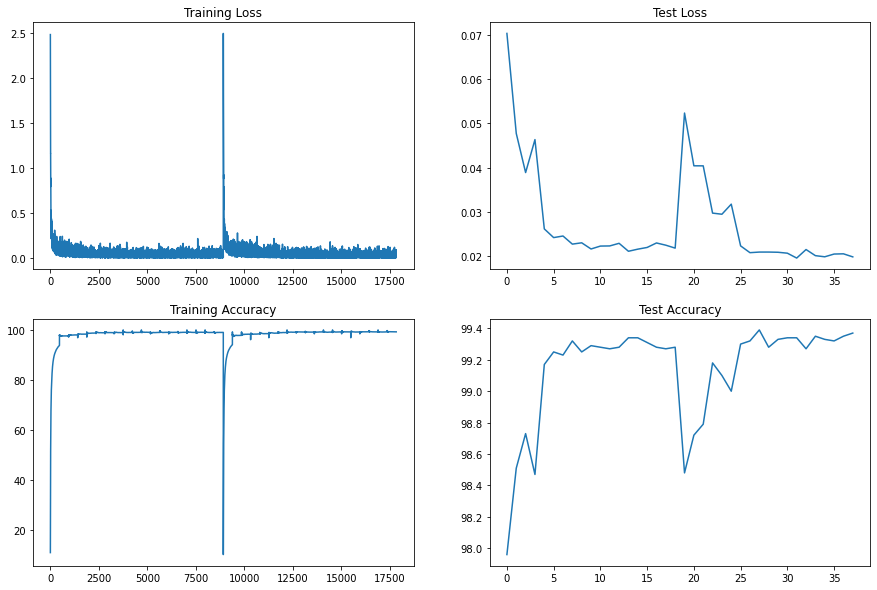

In [16]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [17]:
Analysis ='''
1. No. of parameter have been reduced to < 10,000 
1. Model accuracy has increased to ~ 99%+
1. Reduced model footprint 
1. Training accuracy ~99%, as well as test accuracy ~99% leaves room for model improvement
1. Model still shows almost no overfitting since Training accuracy is similar to Test accuracy
'''

In [18]:
total_params = sum(param.numel() for name, param in  model.named_parameters())

#Summary

In [19]:
from IPython.display import Markdown as md


md(f"""

<h2>Summary</h2>

**Targets**:   {targets} 

----
| Attribute | Value |
|:--- | :--- |
| Training Accuracy | {np.mean(train_acc[-3:])} |
| Test Accuracy | {np.mean(test_acc[-3:])} |
| Trained Parameter count   |{total_params} |
| Total Epochs | {EPOCHS} |

----
**Analysis**: {Analysis}
""")




<h2>Summary</h2>

**Targets**:   
1. Keep *Trainable* parameters to < 10,000
1. Use Regularization techniques like batch normalization, dropout, global average pooling  
1. Use any image Augumentation
1. Increase train and test accuracy above 99.2%
1. Avoid overfitting
 

----
| Attribute | Value |
|:--- | :--- |
| Training Accuracy | 99.23196613987568 |
| Test Accuracy | 99.34666666666665 |
| Trained Parameter count   |8374 |
| Total Epochs | 19 |

----
**Analysis**: 
1. No. of parameter have been reduced to < 10,000 
1. Model accuracy has increased to ~ 99%+
1. Reduced model footprint 
1. Training accuracy ~99%, as well as test accuracy ~99% leaves room for model improvement
1. Model still shows almost no overfitting since Training accuracy is similar to Test accuracy

